# %load latex_std
$$
\newcommand{\x}{\mathbf{x}}
\newcommand{\y}{\mathbf{y}}
\newcommand{\b}{\mathbf{b}}
\newcommand{\c}{\mathbf{c}}
\newcommand{\z}{\mathbf{z}}
\newcommand{\h}{\mathbf{h}}
\newcommand{\w}{\mathbf{w}}
\newcommand{\W}{\mathbf{X}}
\newcommand{\X}{\mathbf{X}}
\newcommand{\KL}{\mathbf{KL}}
\newcommand{\E}{\mathbb{E}}
\newcommand{\ip}{\mathbf{{(i)}}}
\newcommand{\tp}{\mathbf{{(t)}}}
\newcommand{\loss}{\mathcal{L}}
\newcommand{\cost}{\mathcal{L}}
%
% Functions with arguments
\def\xsy#1#2{#1^#2}
$$


# Ideas
- [Andrew Ng](https://www.youtube.com/playlist?list=PLNeKWBMsAzboNdqcm4YY9x7Z2s9n9q_Tb)
- [Luis Serrano](https://www.youtube.com/watch?v=Lpr__X8zuE8)
- [Georgia Tech](https://www.youtube.com/playlist?list=PL254CoWQYPipXzhIRA-1PfB91flX2DuXl)

 
- Linearly separable cloud of points
    - which line to choose, assume many achieve perfect separation ?
        - one with largest margin
            - maximimize the mininimum distance of correctly classified point to line

- Use Gradient Descent to solve !
    - [Geron notebook](external/handson-ml/05_support_vector_machines.ipynb#Linear-SVM-classifier-implementation-using-Batch-Gradient-Descent)
  

Scale dependence
- [Geron notebook](/external/handson-ml/05_support_vector_machines.ipynb#Sensitivity-to-feature-scales)
- e.g., Gaussian kernel exponents has $(x_i - x_j)^2$ term
    - n.b., the $\sigma$ in denominator is a **constant**, not a function of $x$

- Sensitivity to outliers
    - [Geron notebook](external/handson-ml/05_support_vector_machines.ipynb#Sensitivity-to-outliers)

In [1]:
# My standard magic !  You will see this in almost all my notebooks.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

%matplotlib inline

In [2]:
import svm_helper
%aimport svm_helper
svmh = svm_helper.SVM_Helper()

%matplotlib inline


# Support Vector Machines

We now show another type of classifier, based on Support Vector Machines.
(n.b., SVM's can also be used for Regression).

The discussion will be framed as a specific type of transformation that is applied to the input
data.  To simplify the discussion, we focus on binary classifiers.
As we showed with Logistic Classification, we can use a one-versus-many technqiue to
convert it into a $K > 1$ class classifier, by essentially creating a binary classifier for
each $c_i \in C = \{ \y^\ip |x^\ip \in \X \}$.

Logistic Classifiers can be view as applying a linear model $\Theta \x$ to compute a "score",
passing the score through the logistic function (to convert to $[0,1]$ range probability).

The SVM will apply a particular kind of transformation $\phi$ to $\x$ before fitting a linear model.


## Landmarks and the Similarity transformation

$$
\newcommand{\lmk}{\boldsymbol{\ell}}
$$

Let us pick a set of distinguished points $\{ \lmk^{(1)}, \lmk^{(2)}, \ldots \}$ in the input domain.
We will refer to these distinguished points as "landmarks" because we will use
them as reference points from which we will measure the similarity (inverse of distance) of each example $\x^\ip$ in the training set.

In particular, let us choose $n'$ landmarks and let
$$
K(\x, \lmk^\ip)
$$
be a measure of similarity between vector $\x$ and the $i^{th}$ landmark.

$K$ will be referred to as a "similarity function" or "kernel".

Then the transformation of $\x^\ip$ into
$$
\hat\x = [ K(\x^\ip, \lmk^{(1)}), K(\x^\ip, \lmk^{(2)}), \ldots, K(\x^\ip, \lmk^{(n')}),]
$$
is a representation of the original $\x^\ip$ into a "similarity" vector.

We will do linear classification on these transformed features $\hat\x$ rather than the original $\x$.

This new representation will be the basis of a linear classifier (like logistic regression)
that computes a
linear score $s(\hat\x) = \Theta^T \cdot  \hat\x$ from the (transformed) features.
This score will determine the prediction.

Score:
$$
s(\hat\x) = \Theta^T \cdot \hat\x + b
$$

Score to prediction:
$$
\hat{\y} = 
\begin{cases}
0 & \text{if } s(\x) < 0 \\
1 & \text{if } s(\x) \ge 0
\end{cases}
$$
So once again, the dot product is doing a form of "pattern matching" of features,
but now 
- we use transformed features: similarity to landmarks
- the pattern is identifying the relative importance of being similar to each landmark

So far, very similar to Logistic Regression: the score determines the prediction.

One difference is that, in Logistic Regression, we convert the score to a probability
via a sigmoid function:
$$
\hat{p}^\ip = \sigma( s(\x^\ip))
$$
This probability is needed mainly for the Cost function for Logistic Regression (Binary Cross Entropy)
but may be useful as an informative output as well.

We shall soon seen the main difference from Logistic Regression: a similar (but different) cost function.

## Choosing the landmarks

How do we choose the landmarks ?  How many do we choose ?

Let's choose each of the $m$ examples in the training set as a landmark so
that
$\lmk^\ip = \x^\ip$.

This might initially seem to be a large number of landmarks.  Is it possible to choose fewer ?
Yes, and we will let Machine Learning decide which ones matter!

## Cost function

Just like with Logistic Regression, a critical part of the cost function
is a constraint that our predictions are accurate.

For Logistic Regression, we converted the linear score into a probability via the logistic function

$$ \hat{p}^\ip  = \sigma(s(\hat\x^\ip))$$

and used Binary Cross Entropy Loss for each example $i$ (and then sum across examples for total loss:
$$
\loss^\ip = - \left( \y^\ip \log(\hat{p}) + (1-\y^\ip) \log(1-\hat{p})  \right)
$$

In contrast, SVM will use cost function (Hinge Loss) that is similar in form to
Binary Cross entropy.

$$
\loss^\ip = \left( \y^\ip \max(0, - s(\hat\x))  + (1 - \y^\ip) \max(0, s(\hat\x)) \right)
$$

This cost function was chosen such that it can be minimized very quickly via specialized constrained optimizers.  SGD would still work, but would be move slower.

We refer to this loss as the *classification loss*.

To see the similarity between Hinge Loss and Cross Entropy, here
are the two hinge losses (when the hinge is at $0$)

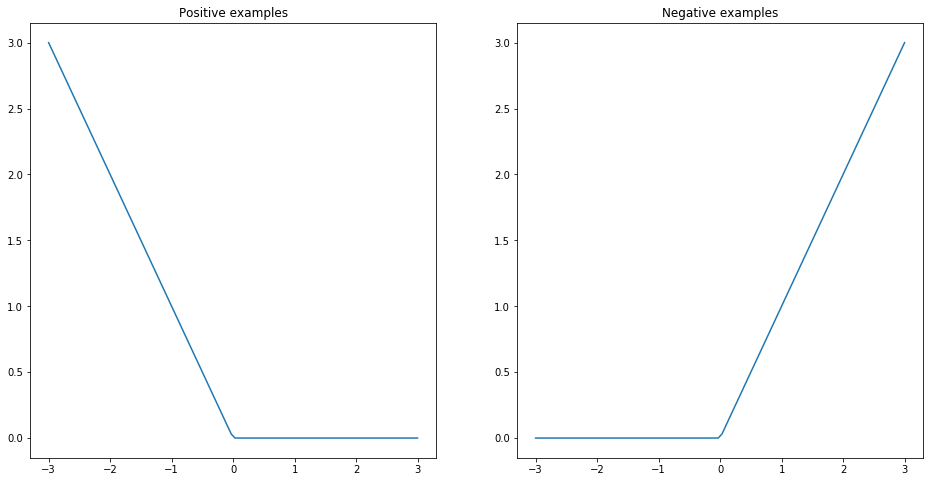

In [3]:
svmh.plot_hinges()

And here are the two sides of the Binary Cross Entropy

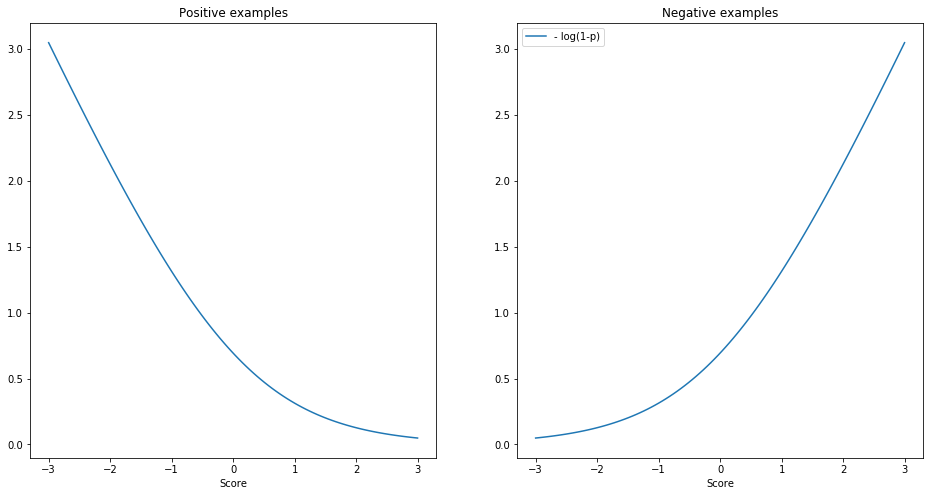

In [4]:
svmh.plot_log_p()

The Binary Cross Entropy and Hinge Loss are quite similar when the hinge point is moved to +1/-1.

In both the Positive and Negative example case, the loss is minimized when the $\max$ is $0$
- large positive scores for positive examples
- large negative scores for negative examples

Rather than having the asymmetry in the two halves of our hinge loss it is more convenient
to have the binary decision be $\{-1, +1 \}$ rather than $\{0,1\}$.

Let $t^\ip$ be
$$t^\ip =
\begin{cases}
+1 \text{ if } \y^\ip = 1 \\
-1 \text{ if } \y^\ip = 0
\end{cases}
$$

so that our targets are now in the range $[-1,+1]$ rather than $[0,1]$.
Doing so will make the product $(t^\ip * s(\x^\ip))$ positive for correct predictions so
we can minimize
$$
\loss^\ip = - \max(0, t^\ip * s(\x^\ip))
$$


### Regularization penalty

The purpose of the classification loss is to enforce correct prediction.
We add one more constraint to the cost function: an L2 regularization penalty on the weights $\Theta$.

One reason for this constraint is that it
forces some $\Theta_i$ to $0$, which means landmark $\lmk^\ip$ is not necessary and we wind up with $m' < m$ landmarks

Once we discuss adding a margin to the hinge loss, we will see a second purpose.

So the final cost (per example) function is a classification error plus a regularization penalty:
$$
    \loss^\ip =  - \max(0, t^\ip * s(\hat\x^\ip) ) + \lambda * \frac{1}{2} \Theta^T \cdot \Theta
$$
where $\lambda$ is multiplier for the strength of the regularization penalty $\frac{1}{2} \Theta^T \cdot \Theta$.


**Aside**

Write penalty with the $\frac{1}{2}$ in front so that the derivative with respect to $\w$ is $\w$.

When written via the Hinge Loss, we can express this as a constrained minimization problem

$$
\begin{array}[llll]\\
\text{minimize } \frac{1}{2} \w \w^T \\
\text{subject to } t^\ip * s(\hat\x^\ip) \ge 1 \text{for } i=1,\ldots,m
\end{array}
$$

### $C$ versus $\lambda$

The L2 regularization penalty is multiplied by $\lambda$, which determines the tradeoff
between correct prediction and sparse $\Theta$.
That is, the correct prediction term is $\frac{1}{\lambda}$ times as important as the regularization
term.

In the SVM literature, rather than weight the regularization term,
one sees the correctness term weighted by the value $C$ rather than the regularization term
weighted by $\lambda$.

$$
C = \frac{1}{\lambda}
$$

Geron writes the classification objective as a constrained minimization problem

$$
\begin{array}[llll]\\
\text{minimize } \frac{1}{2} \w \w^T \\
\text{subject to } t^\ip * s(\hat\x^\ip) \ge 0 \text{ for } i=1,\ldots,m
\end{array}
$$

When written in this minimization form, the $C$ on the constraint (correctness term) can
be interpretted as the Lagrangian Multiplier of the minimization.


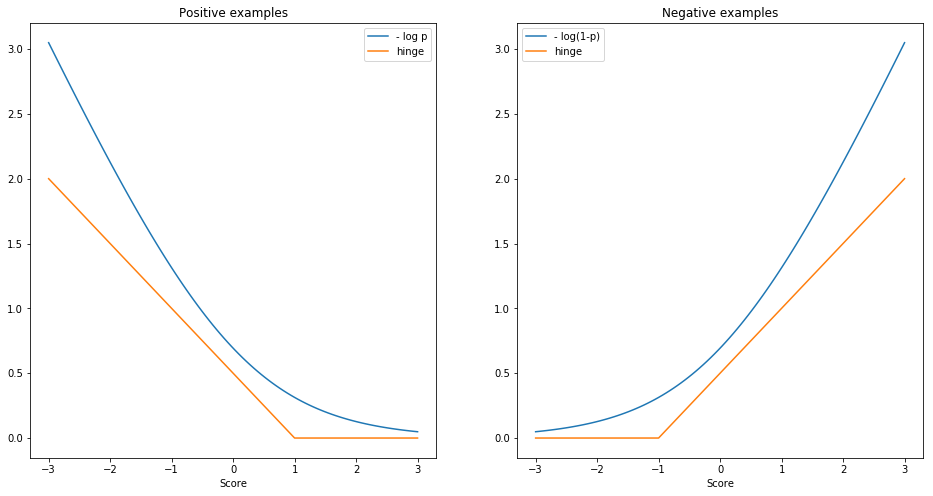

In [5]:
svmh.plot_log_p(hinge_pt=True)

### Strength of L2 penalty: Bias, variance tradeoff


What determines $C$ ?

If $C$ were infinite, we would require **no** correctness violations.
This is called a **hard** margin.

Hard margins are problematic in that
- some training sets may have no solution
- it encourages overfitting of training and poor generalization

A *soft* margin allows (but penalizes) correctness violations, which may lead to better
generalization.

So the choice of $C$ will depend on the tradeoff between fitting the training set well
and good test time generalization.
- if the regularlization penalty is low, $m'$ (the number of landmarks) can be large
    - this encourages overfitting of training
    - so the bias (training error) is low, but the test error (variance) will likely be larger than it would be otherwise
- if the regularization penalty is high, $m'$ will be low
    - this encourages sparsity, resulting in higher bias (training error)
    - but hopefully leads to be test error (variance)
    


## Kernels and the Kernel Trick

We transformed the input $\x$ into a new representation (synthetic features $\hat\x$)
via a function $K$ that we called a kernel.

Not all functions work kernels.
A function $K$ is called a *kernel function* if

$$
K(\x, \lmk) = \phi(\x) \cdot \phi(\lmk)
$$

That is: it has the form of a dot product of a transformation $\phi$ of each argument.

In order for a function to be a Kernel Function, it must satisfy Mercer's Theorem.

A kernel is often a non-linear transformation whose purpose is to make the two classes
linearly separable.

The reason for the restriction of using Kernels as Similarity Functions is
to facilitate the mathematics of optimization
that make solvers for SVM efficient.
(In theory SGD works, but lacking the optimization shortcuts, is very slow).

***Ng** 12.5
Kernels can also be used for Logistic Regression but they are typically only
used in SVM Classifiers as the mathematical tricks only apply in this context (hinge loss ?)

The Gaussian RBF is a very common Kernel function.

## Some Kernels/Similarity functions
[kernels](http://crsouza.com/2010/03/17/kernel-functions-for-machine-learning-applications/#linear)

There are a number of common similarity functions.
We investigate just a handful:

### Linear

The linear similarity

$$
K(\x, \lmk) = \x^T \cdot \lmk + c
$$

so $\phi$ is the identity transformation $\phi(\x) = \x$.

The linear kernel results in something very close to plain logistic regression.

### Gaussian

The Gaussian Radial Basis Function (RBF)

$$
K(\x, \lmk) =  \exp( - \frac{1}{2 \sigma^2} * \mid\mid  \x - \lmk \mid\mid^2 )
$$

is a kernel function (**What is $\phi$??? [see](https://stats.stackexchange.com/questions/35634/how-to-prove-that-the-radial-basis-function-is-a-kernel))

The form of this function is that of a Gaussian distribution with mean $0$ and standard deviation $\sigma$.
The similarity is maximized when $\x$ and the landmark $\lmk$ are close
in Euclidean space (due to the 2-norm $\mid\mid \; \mid\mid^2$)

**Plot this**

When $\sigma$ is small, there is a sharp drop-off from the maximium at $\lmk$ to near-by points.
Conversely, when $\sigma$ is large, the drop-off is much smoother.

Smaller $\sigma$ results in a less sparse $\Theta$ ???

### Importance of normalization of $\x$

Imagine that the various components of $\x$ are on vastly different scales
- suppose $\x_1$ is in "billions of units" (so $\x_1$ is small) but $\x_2$ is in single units (large)

Then, for the Gaussian RBF, the 2-norm will be dominated by the larger dimension, almost to the exclusion of smaller dimensions.

Thus, if the chosen $\phi$ is sensitive to scale (such as the Gaussian RBF) it's important to normalize the training set (across each dimension of features) so that
all features (elements of $\x$) are on similar scale.

## Large Margin Classification

Our binary classification scheme (for all classifiers, not just SVM) has a single decision boundary:
either the score is positive or not.

If we use Hinge Loss, we can move the hinge point away from $0$.
This corresponds to a stricter requirement that
the absolute value of the score exceed some positive, non-zero margin.

Moving the hinge point to $1$:

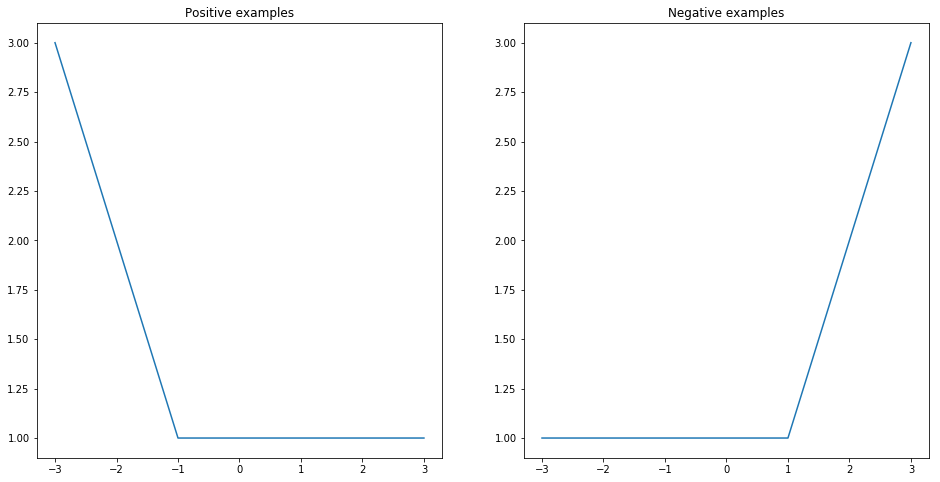

In [6]:
svmh.plot_hinges(hinge_pt=1)

So the cost becomes
$$
    \loss^\ip =  - \max(0, t^\ip * s(\hat\x^\ip) - 1) + \lambda * \frac{1}{2} \Theta^T \cdot \Theta
$$

Thus our goal is no longer to just make $t^\ip * s(\hat\x^\ip)$ positive, but to
make it greater than the hinge value of $1$.

Why a hinge value of $1$ and not something more general ?

Recall that the score $s(\hat\x^\ip)$ is $\Theta^T \cdot \hat\x$.
It is obviously linear in $\Theta$.

Consider the term 
$(\Theta^T \cdot \hat\x)$ versus 
$(\Theta'^T \cdot \hat\x)$ for $\Theta' = \alpha * \Theta$, where $\alpha < 1$.

In order for the classification loss an example to be $0$ in the latter case:
$$
\begin{array}[lll]\\
\Theta'^T \cdot & \hat\x  & \ge & 1 \\
\end{array}
$$

which implies that $\Theta^T \cdot \hat\x  \ge  \frac{1}{\alpha}$

So by  shrinking $\Theta$ to $\alpha * \Theta$ we increase the hinge point and thus
the margin.

Thus, the regularization penalty has a second purpose: to increase the margin.



Which brings us back to the mean of $C$, the multiplier for the classification loss.

The effect of increasing the importance of the classification loss (i.e., increasing $C$)
is to decrease the relative importance of the L2 penalty and hence the need for making $\Theta$ smaller diminishes.
Hence, the margin shrinks with increasing $C$.


## When to use kernels

The choice of the complexity of a kernel depends on the relationship
between $m$, the number of training examples, and $n$, the number of features.

- When $m$ is large (and large relative to $n, m \gg n$) there is a lot of data on which to fit a complicted kernel.
    - however, when $m$ is really large, this can be expensive
- When $m$ is small, the lack of data for fitting suggests a simple, linear kernel or logistic regression
- when $n$ is small, simpler Kernels are Logistic Regression is suggested

## SVM for Regression

SVM's can be used not only for classification but for regression as well.

For classification, the cost function tries to fit all training examples far outside the margin.

For regression, the cost function tries to fit all training examples *within* the margins.
That is, unlike ordinary linear regression, "small" errors (i.e., those fitted values that are off
the fitted line but within the margin) don't contribute to the cost.


## Drawbacks

### Complexity
The SVM may utilize up to $m$ landmarks from the vectors among the training set.
These landmarks are referred to as "support vectors".

As $m$ may be very large, SVM models may consume a lot of memory (in the test phase, not just when being fit).

### Hinge Loss

The Hinge Loss imposes **no** cost for a training example as long as it is within the margin.
So once the example is within the margin, there is no cost reduction in making a "better" fit.
This is most clear when using SVM for regression.

Contrast this with other, continous cost functions, like Binary Cross Entropy (for classification)
or MSE (for regression).  There is always room for improvement (up to a maximum).
So the latter cost functions will continue to make improvements after the Hinge Loss would have stopped.

Depending on the circumstances, the Hinge Loss might have an advantage (reducing over fitting ?)
or might have a disadvantage (high bias).

## SVM in `sklearn`

`sklearn` has several SVM algorithms (using different optimization techniques) that, mathematically,
should yield equivalent results.
The difference is that some optimize for time (faster solution) versus space (ability to handle bigger
training sets) versus being more general solvers.

According to Geron (page 194), the following should be equivalent
- `LinearSVC(C=1, loss="hinge")`
- `SVC(C=1,kernel="linear")`
- `SGDClassifier(loss="hinge", alpha=1/(m*C))`

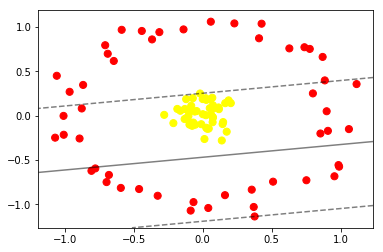

In [30]:
Xc, yc = svmh.make_circles()
svm_clf = svmh.circles_linear(Xc, yc)

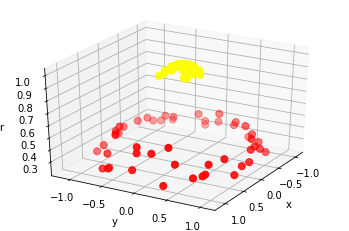

In [44]:
X_w_rbf = svmh.circles_rbf_transform(Xc)
_= svmh.plot_3D(X=X_w_rbf, y=yc )

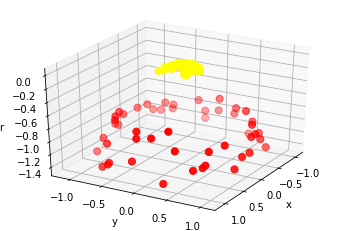

In [42]:
X_w_rad = svmh.circles_radius_transform(Xc)
_= svmh.plot_3D(X=X_w_rad, y=yc )

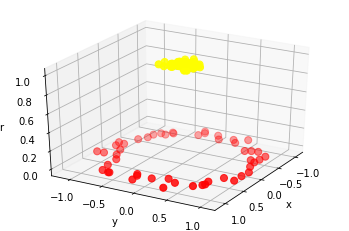

In [46]:
X_w_sq = svmh.circles_square_transform(Xc)
_= svmh.plot_3D(X=X_w_sq, y=yc )